# Machine Learning Models

In [17]:
import polars as pl
from matplotlib import pyplot as plt

df_long = pl.read_parquet("../data/processed_data/df_long.parquet")

In [18]:
df_long

Date,Drink,Views
date,str,i64
2020-07-01,"""""Matcha""""",1969
2020-07-02,"""""Matcha""""",1960
2020-07-03,"""""Matcha""""",1920
2020-07-04,"""""Matcha""""",1822
2020-07-05,"""""Matcha""""",1954
…,…,…
2025-11-27,"""""Iced coffee""""",131
2025-11-28,"""""Iced coffee""""",141
2025-11-29,"""""Iced coffee""""",134


## Feature Engineering
Create time-based features and per-drink lag/rolling statistics to help models learn temporal patterns.

In [19]:
# Convert to pandas for feature engineering
import pandas as pd
import numpy as np

pdf = df_long.sort(["Drink", "Date"]).to_pandas()
pdf["Date"] = pd.to_datetime(pdf["Date"])  # ensure datetime

# Time features
pdf["year"] = pdf["Date"].dt.year
pdf["month"] = pdf["Date"].dt.month
pdf["dayofweek"] = pdf["Date"].dt.dayofweek
pdf["is_weekend"] = (pdf["dayofweek"] >= 5).astype(int)

# Per-Drink lag features
pdf["lag1"] = pdf.groupby("Drink")["Views"].shift(1)
pdf["lag7"] = pdf.groupby("Drink")["Views"].shift(7)
pdf["lag14"] = pdf.groupby("Drink")["Views"].shift(14)

# Per-Drink rolling features
pdf["roll7_mean"] = (
    pdf.groupby("Drink")["Views"].transform(lambda s: s.rolling(window=7, min_periods=1).mean())
)
pdf["roll7_std"] = (
    pdf.groupby("Drink")["Views"].transform(lambda s: s.rolling(window=7, min_periods=1).std())
)

# Drop rows where essential lags are missing (start of series)
pdf = pdf.dropna(subset=["lag1", "lag7"])

## Train/Test Split and Encoding
Split by date and one-hot encode `Drink` for model input.

In [20]:
# Train/Test split by date threshold
cutoff = pd.Timestamp(2025, 1, 1)
train_pdf = pdf[pdf["Date"] < cutoff].copy()
test_pdf = pdf[pdf["Date"] >= cutoff].copy()

# One-hot encode Drink
train_pdf = pd.get_dummies(train_pdf, columns=["Drink"], drop_first=False)
test_pdf = pd.get_dummies(test_pdf, columns=["Drink"], drop_first=False)

# Align columns (in case test is missing a category)
test_pdf = test_pdf.reindex(columns=train_pdf.columns, fill_value=0)

# Features and target
target = "Views"
feature_cols = [
    c for c in train_pdf.columns
    if c not in ["Views", "Date"]
]

X_train = train_pdf[feature_cols].values
y_train = train_pdf[target].values
X_test = test_pdf[feature_cols].values
y_test = test_pdf[target].values

X_train.shape, X_test.shape

((16380, 19), (3350, 19))

In [21]:
# ...existing code...
nan_counts = train_pdf[feature_cols].isna().sum().sort_values(ascending=False)
print("Columns with NaNs:\n", nan_counts[nan_counts > 0])
# ...existing code...
# ...existing code...
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
X_train = imputer.fit_transform(train_pdf[feature_cols])
y_train = train_pdf[target].values
X_test  = imputer.transform(test_pdf[feature_cols])
y_test  = test_pdf[target].values

# Optional: confirm no NaNs remain
print("Train NaNs remaining:", np.isnan(X_train).sum())
print("Test NaNs remaining:", np.isnan(X_test).sum())
# ...existing code...

Columns with NaNs:
 lag14    70
dtype: int64
Train NaNs remaining: 0
Test NaNs remaining: 0


## Train Models
Train several regressors and store predictions for comparison.

In [22]:
# Metrics helper
from sklearn.metrics import mean_absolute_error, mean_squared_error


def evaluate(actual, pred, name):
    mae = mean_absolute_error(actual, pred)
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mape = np.mean(np.abs((actual - pred) / np.clip(actual, 1e-8, None))) * 100
    return {"MAE": mae, "RMSE": rmse, "MAPE": mape, "name": name}

# Train models
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor

models = {
    "LinearRegression": LinearRegression(),
    "Ridge(alpha=1.0)": Ridge(alpha=1.0),
    "RandomForest": RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "HistGradientBoosting": HistGradientBoostingRegressor(random_state=42)
}

results = {}
preds_store = {}

for name, mdl in models.items():
    mdl.fit(X_train, y_train)
    pred = mdl.predict(X_test)
    preds_store[name] = pred
    results[name] = evaluate(y_test, pred, name)

# Show quick summary
{n: {k: round(v[k], 3) for k in ["MAE", "RMSE", "MAPE"]} for n, v in results.items()}

{'LinearRegression': {'MAE': 1077.486,
  'RMSE': np.float64(1472.765),
  'MAPE': np.float64(233158707246.011)},
 'Ridge(alpha=1.0)': {'MAE': 1072.975,
  'RMSE': np.float64(1466.675),
  'MAPE': np.float64(232623246496.823)},
 'RandomForest': {'MAE': 130.555,
  'RMSE': np.float64(1007.538),
  'MAPE': np.float64(638442968.119)},
 'GradientBoosting': {'MAE': 192.846,
  'RMSE': np.float64(2585.6),
  'MAPE': np.float64(6003015227.163)},
 'HistGradientBoosting': {'MAE': 280.908,
  'RMSE': np.float64(1204.303),
  'MAPE': np.float64(6870579515.75)}}

## Model Comparison
Tabulate metrics and visualize performance across models.


MODEL COMPARISON (lower is better):
                              MAE         RMSE                 MAPE
RandomForest           130.555332  1007.538134     638442968.119383
HistGradientBoosting   280.908223  1204.303165    6870579515.750427
Ridge(alpha=1.0)      1072.975424  1466.675322  232623246496.822601
LinearRegression      1077.485587  1472.764785  233158707246.011108
GradientBoosting       192.846023  2585.599769      6003015227.1628


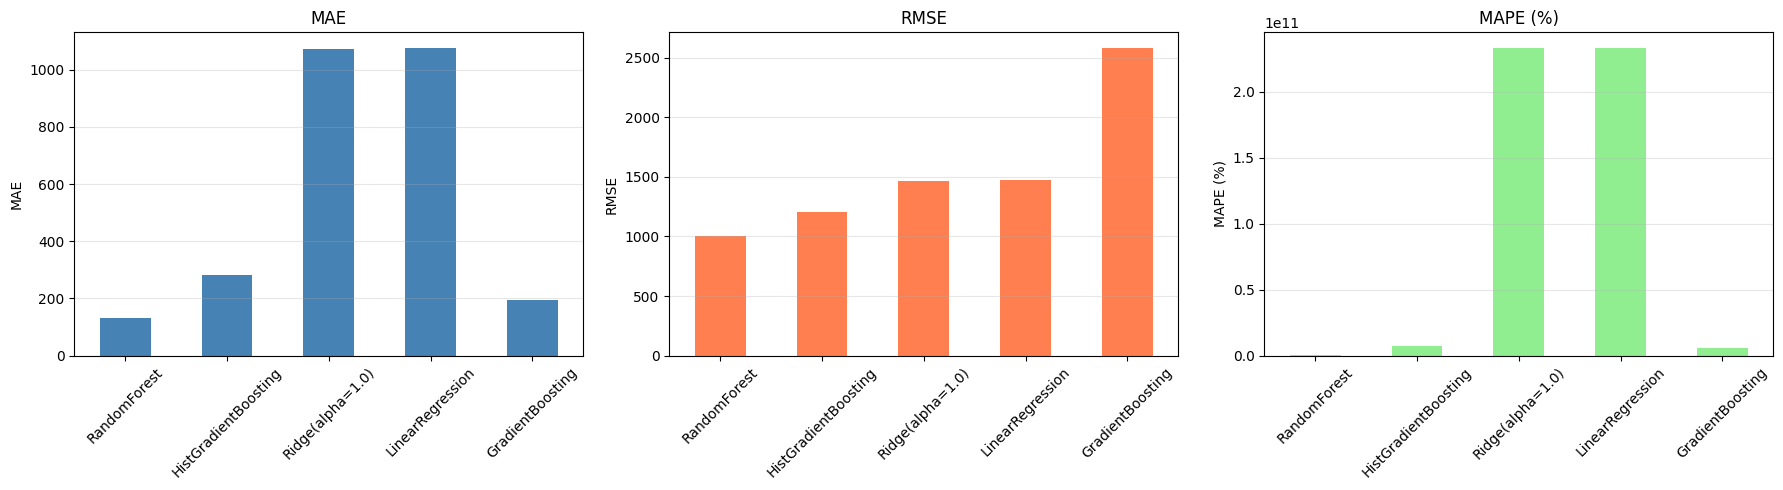

In [23]:
# Comparison DataFrame
comp_df = pd.DataFrame(results).T
comp_df = comp_df.sort_values("RMSE")
print("\nMODEL COMPARISON (lower is better):")
print(comp_df[["MAE", "RMSE", "MAPE"]].round(3))

# Bar charts of metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
comp_df.plot(kind="bar", y="MAE", ax=axes[0], legend=False, color="steelblue")
axes[0].set_title("MAE")
axes[0].set_ylabel("MAE")
axes[0].tick_params(axis="x", rotation=45)
axes[0].grid(True, alpha=0.3, axis="y")

comp_df.plot(kind="bar", y="RMSE", ax=axes[1], legend=False, color="coral")
axes[1].set_title("RMSE")
axes[1].set_ylabel("RMSE")
axes[1].tick_params(axis="x", rotation=45)
axes[1].grid(True, alpha=0.3, axis="y")

comp_df.plot(kind="bar", y="MAPE", ax=axes[2], legend=False, color="lightgreen")
axes[2].set_title("MAPE (%)")
axes[2].set_ylabel("MAPE (%)")
axes[2].tick_params(axis="x", rotation=45)
axes[2].grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.show()

## Visual Comparison of Top Models
Overlay predictions of the top 3 models against actuals.

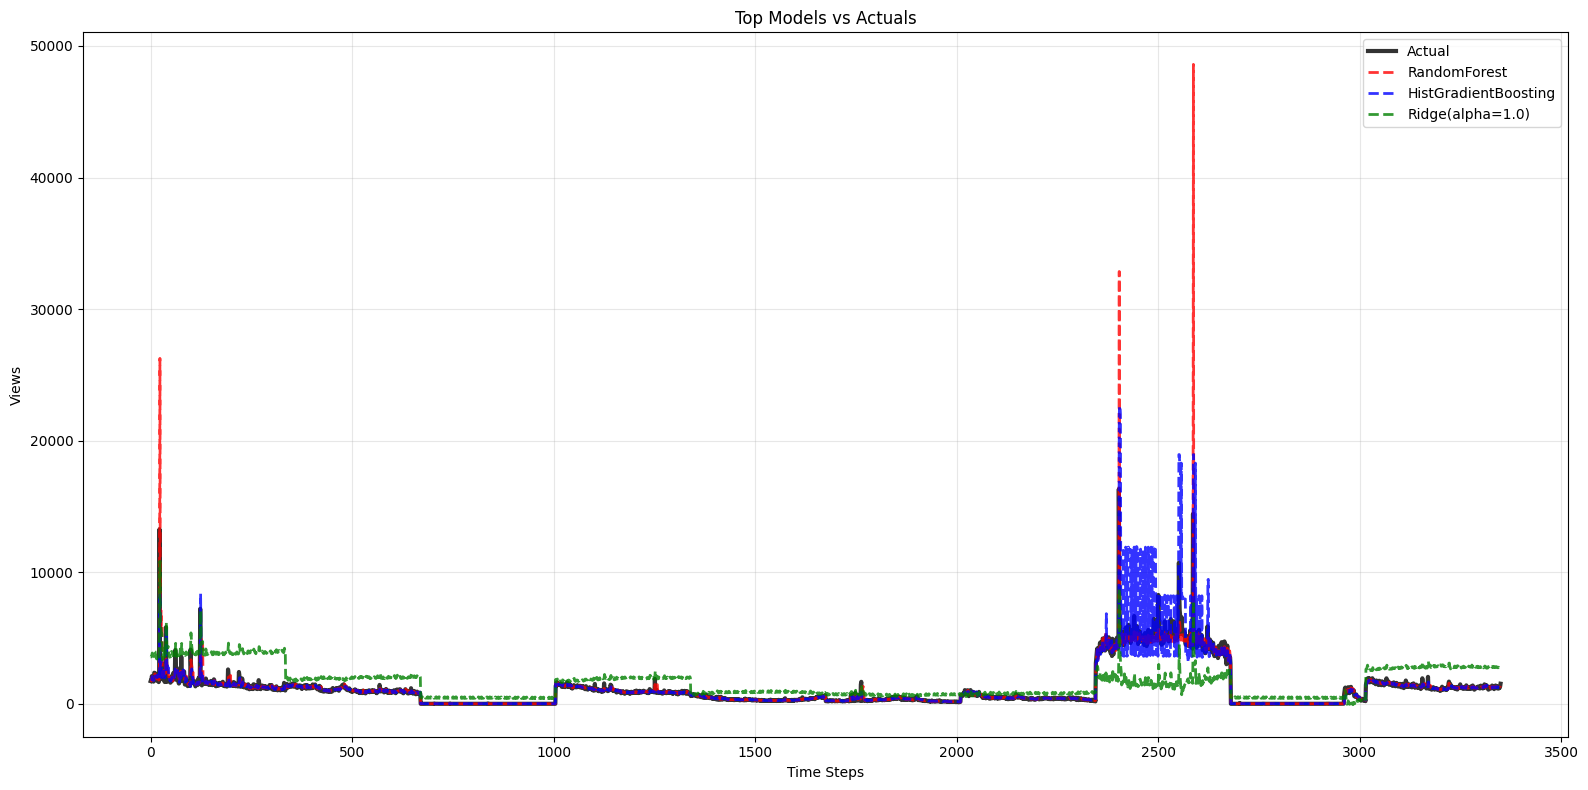

In [28]:
# Overlay plot for top 3 models
k = 3
best_models = comp_df.head(k).index.tolist()

plt.figure(figsize=(16, 8))
plt.plot(y_test, label="Actual", linewidth=3, color="black", alpha=0.8)
colors = ["red", "blue", "green", "orange", "purple"]
for i, name in enumerate(best_models):
    plt.plot(preds_store[name], label=name, linestyle="--", alpha=0.8, linewidth=2, color=colors[i])

plt.title("Top Models vs Actuals")
plt.xlabel("Time Steps")
plt.ylabel("Views")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Individual Model Performance
Detailed comparison of each model's predictions against actual values.

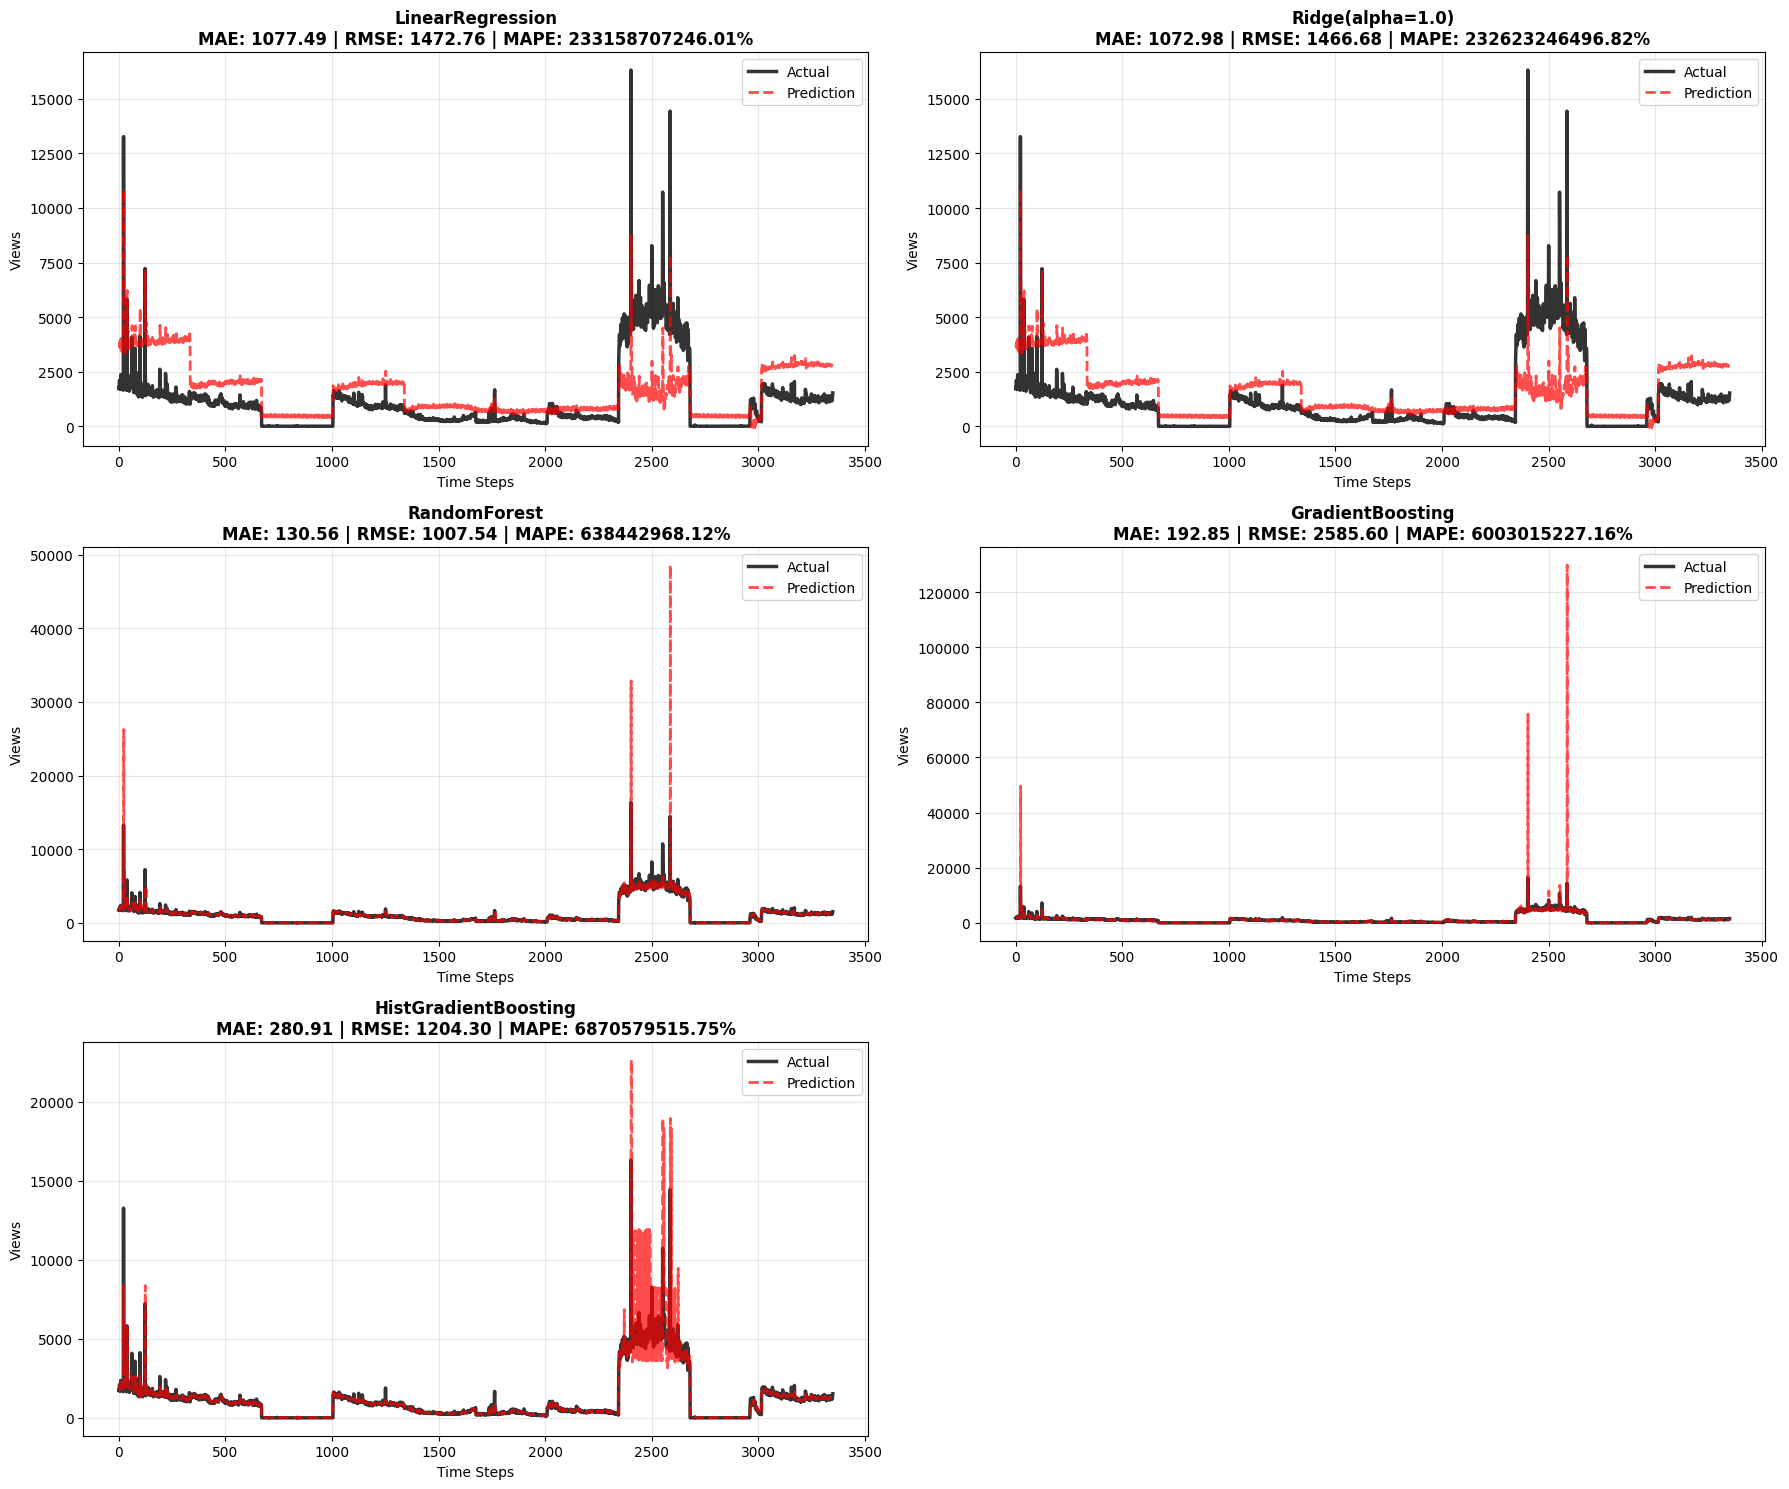

In [29]:
# Create subplots for each model
num_models = len(preds_store)
cols = 2
rows = (num_models + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(18, 5 * rows))
axes = axes.flatten()

for idx, (model_name, pred) in enumerate(preds_store.items()):
    ax = axes[idx]
    ax.plot(y_test, label="Actual", linewidth=2.5, color="black", alpha=0.8)
    ax.plot(pred, label="Prediction", linestyle="--", linewidth=2, alpha=0.7, color="red")
    
    # Add metrics to subplot title
    mae = results[model_name]["MAE"]
    rmse = results[model_name]["RMSE"]
    mape = results[model_name]["MAPE"]
    
    ax.set_title(f"{model_name}\nMAE: {mae:.2f} | RMSE: {rmse:.2f} | MAPE: {mape:.2f}%", fontweight="bold")
    ax.set_xlabel("Time Steps")
    ax.set_ylabel("Views")
    ax.legend(loc="best")
    ax.grid(True, alpha=0.3)

# Hide unused subplots
for idx in range(num_models, len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

**Conclusio**

Random Forest and Gradient Boosting have good performances compared to the other models.